# Convolutional Neural Network Models for Human Activity Recognition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Load dataset

In [2]:
from utils import load_dataset

In [6]:
X_train, y_train = load_dataset(group='train', prefix='HARDataset/')
X_test, y_test = load_dataset(group='test', prefix='HARDataset/')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7352, 128, 9), (7352, 1), (2947, 128, 9), (2947, 1))

In [13]:
y_train = tf.keras.utils.to_categorical(y_train - 1)
y_test = tf.keras.utils.to_categorical(y_test - 1)

## Fit and evaluate the model

In [14]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [79]:
def create_model(n_filters=64, kernel_size=3):
  return tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_timesteps, n_features)),
    tf.keras.layers.Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(n_outputs)
  ])

In [44]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 126, 64)           1792      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 124, 64)           12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 124, 64)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3968)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               396900    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

In [30]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [31]:
EPOCHS = 10
BATCH_SIZE = 32

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 2s 294us/sample - loss: 0.3878 - accuracy: 0.8458 - val_loss: 0.4449 - val_accuracy: 0.8527
Epoch 2/10
7352/7352 [==============================] - 2s 256us/sample - loss: 0.1444 - accuracy: 0.9436 - val_loss: 0.4957 - val_accuracy: 0.8704
Epoch 3/10
7352/7352 [==============================] - 2s 263us/sample - loss: 0.1176 - accuracy: 0.9518 - val_loss: 0.4299 - val_accuracy: 0.8975
Epoch 4/10
7352/7352 [==============================] - 2s 230us/sample - loss: 0.1070 - accuracy: 0.9538 - val_loss: 0.4955 - val_accuracy: 0.8823
Epoch 5/10
7352/7352 [==============================] - 2s 238us/sample - loss: 0.1022 - accuracy: 0.9562 - val_loss: 0.4915 - val_accuracy: 0.9070
Epoch 6/10
7352/7352 [==============================] - 2s 251us/sample - loss: 0.0979 - accuracy: 0.9561 - val_loss: 0.6993 - val_accuracy: 0.8476
Epoch 7/10
7352/7352 [==============================] - 2s 216us

In [80]:
def evaluate_model(X_train, y_train, X_test, y_test, n_filters=64, kernel_size=3):
  model = create_model(n_filters=n_filters, kernel_size=kernel_size)
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
  _, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
  return accuracy

In [49]:
def run_experiment(params, n_repeat=10):
  all_scores = list()
  for p in params:
    scores = list()
    for i in range(n_repeat):
      score = evaluate_model(X_train, y_train, X_test, y_test, n_filters=p)
      scores.append(score)
    all_scores.append(scores)
  return all_scores

In [81]:
def run_experiment_kernel_size(params, n_repeat=10):
  all_scores = list()
  for p in params:
    scores = list()
    for i in range(n_repeat):
      score = evaluate_model(X_train, y_train, X_test, y_test, kernel_size=p)
      scores.append(score)
    all_scores.append(scores)
  return all_scores

## Tuning
### Data preprocessing

In [38]:
def plot_variable_distribution(X_train):
  # Remove overlap
  cut = X_train.shape[1] // 2
  X_long = X_train[:, -cut:, :]
  # Flatten the windows
  X_long = X_long.reshape((-1, X_train.shape[2]))
  # Plot the histogram
  plt.figure(figsize=(12, 9))
  for i in range(X_long.shape[1]):
    ax = plt.subplot(X_long.shape[1], 1, i + 1)
    ax.set_xlim(-1, 1)
    plt.hist(X_long[:, i], bins=100)
  plt.show()

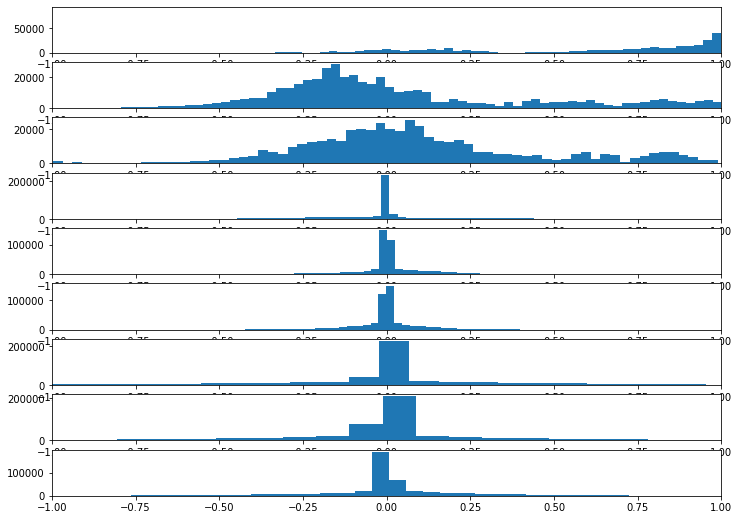

In [39]:
plot_variable_distribution(X_train)

In [41]:
from sklearn.preprocessing import StandardScaler

def scale_dataset(X_train, X_test):
  sc = StandardScaler()
  # Remove overlap
  cut = X_train.shape[1] // 2
  X_long = X_train[:, -cut:, :]
  # Flatten the windows
  X_long = X_long.reshape((-1, X_train.shape[2]))
  X_train_scale = X_train.reshape((-1, X_train.shape[2]))
  X_test_scale = X_test.reshape((-1, X_train.shape[2]))

  sc.fit(X_long)
  X_train_scale = sc.transform(X_train_scale)
  X_test_scale = sc.transform(X_test_scale)
  return X_train_scale, X_test_scale

In [42]:
X_train_scale, X_test_scale = scale_dataset(X_train, X_test)

In [45]:
model = create_model()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [46]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 2s 265us/sample - loss: 0.3866 - accuracy: 0.8456 - val_loss: 0.3243 - val_accuracy: 0.8951
Epoch 2/10
7352/7352 [==============================] - 2s 253us/sample - loss: 0.1342 - accuracy: 0.9464 - val_loss: 0.3678 - val_accuracy: 0.8894
Epoch 3/10
7352/7352 [==============================] - 2s 247us/sample - loss: 0.1282 - accuracy: 0.9483 - val_loss: 0.2580 - val_accuracy: 0.9121
Epoch 4/10
7352/7352 [==============================] - 2s 208us/sample - loss: 0.1055 - accuracy: 0.9535 - val_loss: 0.2871 - val_accuracy: 0.9009
Epoch 5/10
7352/7352 [==============================] - 2s 219us/sample - loss: 0.1047 - accuracy: 0.9538 - val_loss: 0.3487 - val_accuracy: 0.8819
Epoch 6/10
7352/7352 [==============================] - 2s 220us/sample - loss: 0.1119 - accuracy: 0.9536 - val_loss: 0.3807 - val_accuracy: 0.8918
Epoch 7/10
7352/7352 [==============================] - 2s 227us

### Number of Filters

In [50]:
n_params = [8, 16, 32, 64, 128, 256]
all_scores = run_experiment(n_params)

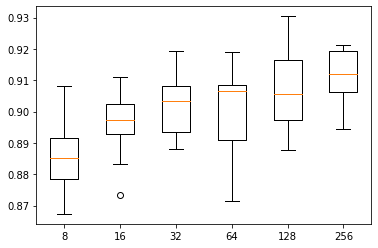

In [52]:
plt.boxplot(all_scores, labels=n_params);

### Kernel size

In [82]:
n_params = [2, 3, 5]
all_scores = run_experiment_kernel_size(n_params)

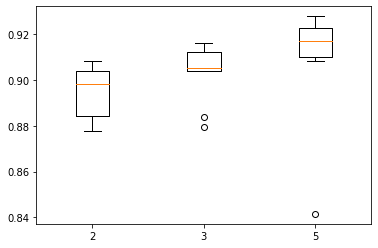

In [83]:
plt.boxplot(all_scores, labels=n_params);

## Multi-headed CNN

In [72]:
def create_multi_headed_model():
  # Head 1
  input1 = tf.keras.layers.Input(shape=(n_timesteps, n_features))
  conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input1)
  drop1 = tf.keras.layers.Dropout(0.5)(conv1)
  pool1 = tf.keras.layers.MaxPool1D(pool_size=2)(drop1)
  flat1 = tf.keras.layers.Flatten()(pool1)
  # Head 2
  input2 = tf.keras.layers.Input(shape=(n_timesteps, n_features))
  conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(input2)
  drop2 = tf.keras.layers.Dropout(0.5)(conv2)
  pool2 = tf.keras.layers.MaxPool1D(pool_size=2)(drop2)
  flat2 = tf.keras.layers.Flatten()(pool2)
  # Head 3
  input3 = tf.keras.layers.Input(shape=(n_timesteps, n_features))
  conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=11, activation='relu')(input3)
  drop3 = tf.keras.layers.Dropout(0.5)(conv3)
  pool3 = tf.keras.layers.MaxPool1D(pool_size=2)(drop3)
  flat3 = tf.keras.layers.Flatten()(pool3)
  # Merge
  merge = tf.keras.layers.concatenate([flat1, flat2, flat3])
  # Interpretation
  dense1 = tf.keras.layers.Dense(100, activation='relu')(merge)
  outputs = tf.keras.layers.Dense(n_outputs)(dense1)
  # Model
  model = tf.keras.Model(inputs=[input1, input2, input3], outputs=outputs)
  return model

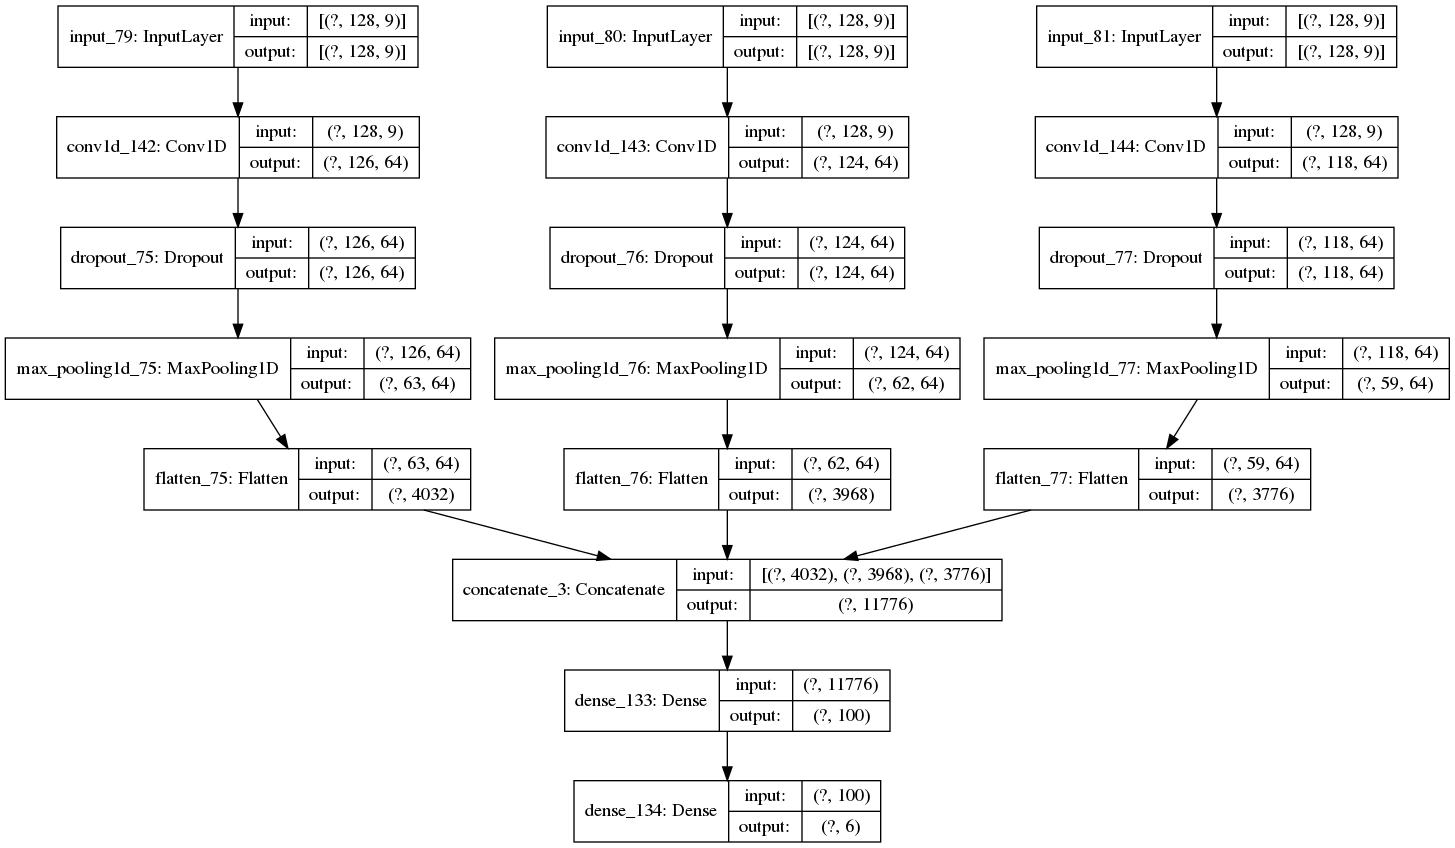

In [73]:
model = create_multi_headed_model()
tf.keras.utils.plot_model(model, show_shapes=True)

In [74]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [75]:
model.fit([X_train, X_train, X_train],
          y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=([X_test, X_test, X_test], y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 3s 369us/sample - loss: 0.3327 - accuracy: 0.8675 - val_loss: 0.2913 - val_accuracy: 0.9002
Epoch 2/10
7352/7352 [==============================] - 2s 266us/sample - loss: 0.1189 - accuracy: 0.9474 - val_loss: 0.2495 - val_accuracy: 0.8975
Epoch 3/10
7352/7352 [==============================] - 2s 275us/sample - loss: 0.1081 - accuracy: 0.9520 - val_loss: 0.2704 - val_accuracy: 0.9104
Epoch 4/10
7352/7352 [==============================] - 2s 274us/sample - loss: 0.1012 - accuracy: 0.9547 - val_loss: 0.2605 - val_accuracy: 0.9247
Epoch 5/10
7352/7352 [==============================] - 2s 271us/sample - loss: 0.0936 - accuracy: 0.9595 - val_loss: 0.2806 - val_accuracy: 0.9128
Epoch 6/10
7352/7352 [==============================] - 2s 263us/sample - loss: 0.0937 - accuracy: 0.9577 - val_loss: 0.2315 - val_accuracy: 0.9182
Epoch 7/10
7352/7352 [==============================] - 2s 266us